In [1]:
# Memeriksa Instalasi tensorFlow
!pip show tensorflow

Name: tensorflow
Version: 2.17.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tf_keras


In [2]:
# Menginstal TensorFlow (jika tidak Ada)
!pip install tensorflow

Preprocessing

In [3]:
# Mingimpor Pustaka
from google.colab import drive

import os
import numpy as np

from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

import zipfile
import matplotlib.pyplot as plt

Memuat Data

In [4]:
# Mengatur lokasi path file yang dipakai di google drive
drive.mount('/content/drive', force_remount = True)
os.chdir('/content/drive/MyDrive')

Mounted at /content/drive


In [5]:
# Menyimpan lokasi direktori dataset di Google Drive
dataset_path = '/content/drive/MyDrive/garbage_classification'

In [6]:
# Memuat dataset gambar 'sampah' dari google drive
# Membagi dataset gambar 'sampah' menjadi data training dan validasi
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2, # memisahkan 20% data untuk validasi
    subset="training",
    seed=123,
    image_size=(128, 128), # menetapkan ukuran gambar yang konsisten
    batch_size=32
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2, # memisahkan 20% data untuk validasi
    subset="validation",
    seed=123,
    image_size=(128, 128), # menetapkan ukuran gambar yang konsisten
    batch_size=32
)

class_names = train_ds.class_names
num_classes = len(class_names)

Found 15515 files belonging to 12 classes.
Using 12412 files for training.
Found 15515 files belonging to 12 classes.
Using 3103 files for validation.


Normalisasi Data

In [7]:
# menghindari nilai piksel yang besar
normalization_layer = layers.Rescaling(1./255)

Augmentasi Data

In [8]:
# Melakukan augmentasi data pada dataset training
# Menerapkan normalisasi pada dataset training dan validasi.
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(normalization_layer(x)), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

Optimasi dengan Prefetching, caching, shuffling

In [9]:
# Meningkatkan efisiensi pemrosesan data menggunakan caching, shuffling, dan prefetching
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

for image_batch, labels_batch in train_ds.take(1):
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", labels_batch.shape)

Image batch shape:  (32, 128, 128, 3)
Label batch shape:  (32,)


Visualisasi Data

Run kembali untuk melihat output yang lain

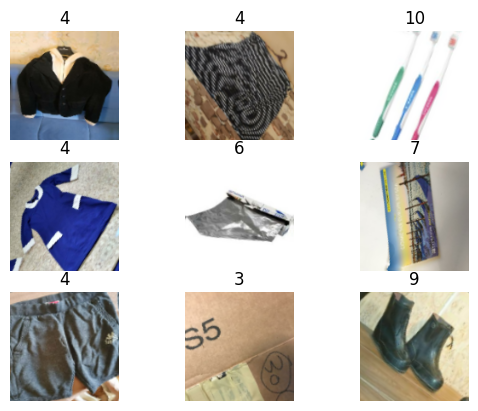

In [10]:
# Menampilkan contoh gambar dari batch data training
for image_batch, label_batch in train_ds.take(1):
  plt.figure(figure=(10, 10))
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy())
    plt.title(int(label_batch[i]))
    plt.axis("off")
  plt.show()

# Model

In [18]:
# Menampilkan jumlah GPU yang tersedia
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Inisialisasi Dataset training dan Validasi
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(128, 128),
    batch_size=32
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(128, 128),
    batch_size=32
)

# Menentukan Jumlah Kelas
num_classes = len(train_ds.class_names)

# Mendefinisikan Model CNN
def create_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])

    # Mencompile model
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Menampilkan model
model = create_model()
model.summary()

Num GPUs Available:  1
Found 15515 files belonging to 12 classes.
Using 12412 files for training.
Found 15515 files belonging to 12 classes.
Using 3103 files for validation.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 63, 63, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 30, 30, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 14, 14, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │           3,084 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 130,252 (508.80 KB)

 Trainable params: 129,804 (507.05 KB)

 Non-trainable params: 448 (1.75 KB)

Compile Model

In [19]:
model = create_model()

# Menentukan Mixed Precision
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('float32')
mixed_precision.set_global_policy(policy)

# Menentukan Callback
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('/content/best_model.keras', save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
]

# Menentukan Parameter Pelatihan
num_train_samples = 12412
num_val_samples = 3103

batch_size = 32
steps_per_epoch = num_train_samples // batch_size
validation_steps = num_val_samples // batch_size

train_ds = train_ds.repeat()
val_ds = val_ds.repeat()

# Melatih model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 639s 2s/step - accuracy: 0.1853 - loss: 2.3798 - val_accuracy: 0.4391 - val_loss: 1.9332 - learning_rate: 1.0000e-05
Epoch 2/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 60s 140ms/step - accuracy: 0.4348 - loss: 1.8779 - val_accuracy: 0.5080 - val_loss: 1.6763 - learning_rate: 1.0000e-05
Epoch 3/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 53s 136ms/step - accuracy: 0.4907 - loss: 1.7002 - val_accuracy: 0.5217 - val_loss: 1.5548 - learning_rate: 1.0000e-05
Epoch 4/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 52s 133ms/step - accuracy: 0.5079 - loss: 1.6064 - val_accuracy: 0.5321 - val_loss: 1.4919 - learning_rate: 1.0000e-05
Epoch 5/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 54s 139ms/step - accuracy: 0.5228 - loss: 1.5503 - val_accuracy: 0.5383 - val_loss: 1.4459 - learning_rate: 1.0000e-05
Epoch 6/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 53s 137ms/step - accuracy: 0.5295 - loss: 1.5034 - val_accuracy: 0.5477 - val_loss: 1.3997 - learning_rate: 1.0000e-05
Epoch 7/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 50s 129m

In [20]:
# Cetak Akurasi Model
test_loss, test_acc = model.evaluate(val_ds, steps=1000)
print(f"Test accuracy: {test_acc}")


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 110s 110ms/step - accuracy: 0.5869 - loss: 1.2857
Test accuracy: 0.5865895748138428
